In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D

from tqdm import tqdm_notebook

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import numpy as np

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

from xyz2mol import *

# Load a small dataset of 200 isomers of C7O9

In [13]:
mols = list()
smiles = [i.strip('\n') for i in open('small_dataset.smi', 'r').readlines()]
for smi in tqdm_notebook(smiles):
    mols.append(Chem.MolFromSmiles(smi))

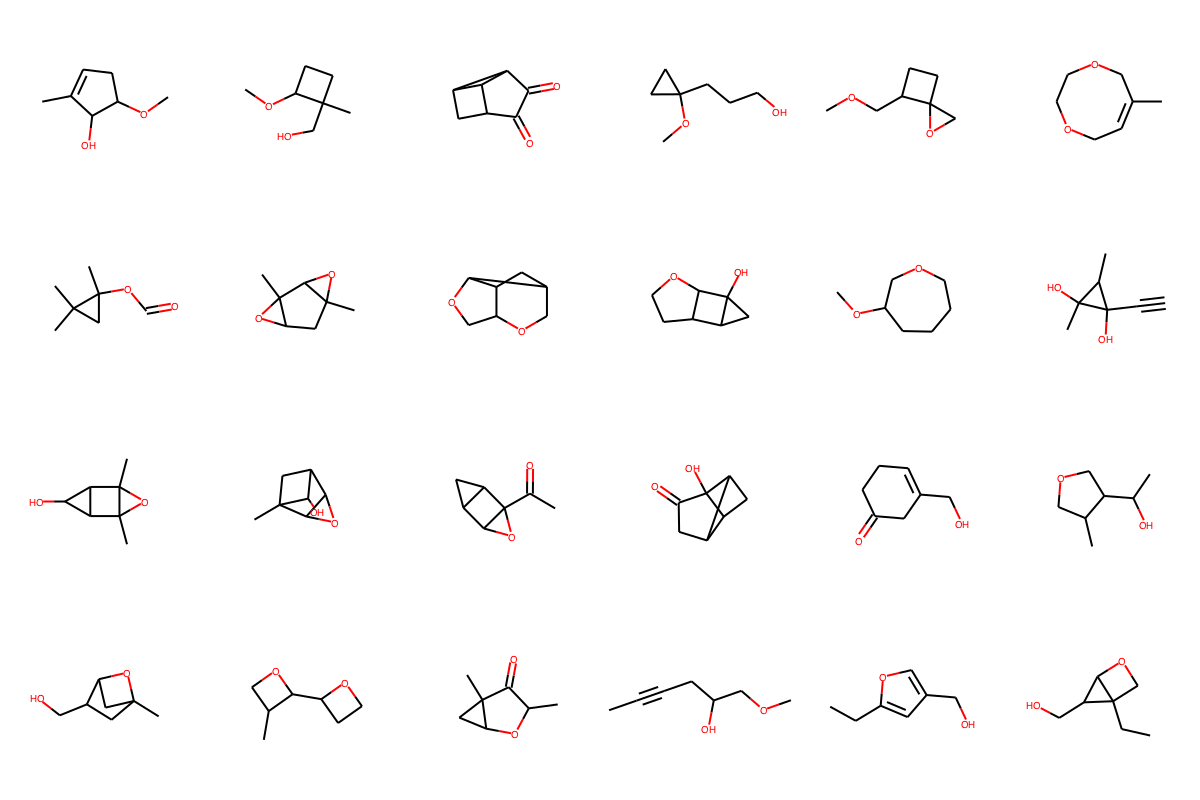

In [14]:
Draw.MolsToGridImage(mols[:24], molsPerRow=6)

# Calculate EDMs and atom identities

In [11]:
def getEDM(mol):
    #get 3d coords
    m3 = Chem.AddHs(mol)
    embed = AllChem.EmbedMolecule(m3)
    if embed+1:  
        m3 = Chem.RemoveHs(m3)
        conformer = m3.GetConformer(0)
        positions = conformer.GetPositions()
        return positions
    else:
        return None

In [12]:
edms = list()
atomidx = list()
for m in tqdm_notebook(mols):
    points = getEDM(m)
    if points is None:
        None
    else:
        edm = pdist(points)
        edms.append(edm)
        
        atoms = np.array([i.GetAtomicNum() for i in m.GetAtoms()])
        atomidx.append(atoms)

# [exploratory] GMM fitting on data, with PCA to reduce dimensionality.

Are EDM's noisy?

This uses code from https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

To do: implement with EDM only + conditioned on binary variable for atom identity using PyMC3


First, reshape by flattening the matrices into (n,1) of flat features because sklearn likes that:

In [16]:
edms = np.array(edms)

# PCA:
We can reduce the number of dimensions substantially using a PCA, and then just turn it back into full number later using the inverse_transform method:

In [18]:
##reduce noise using pca?
pca = PCA(0.99, whiten=True) ##keep 99 percent of variance. 
data = pca.fit_transform(edms)

In [19]:

print('Went from:', edms.shape, 'dimensions to:', data.shape)

Went from: (184, 36) dimensions to: (184, 24)


In [20]:
##Stacking EDMs onto atom identities:

data = np.hstack([data, np.array(atomidx[:200])])

# GMM:

How many components does the GMM need? Low AIC is better. 
The below plots AIC vs dimensions, and shows we need a lot of dims for just 13 atoms... it might become infeasible for drug like molecules but this is just a baseline.

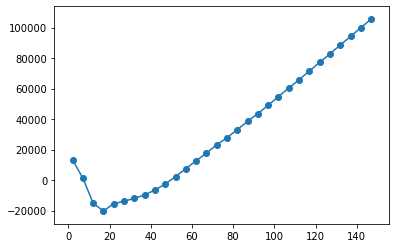

In [22]:
n_components = np.arange(2, 150, 5)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data[:1000]).aic(data) for model in models]
plt.plot(n_components, aics);
plt.scatter(n_components, aics);

In [23]:
gmm = GaussianMixture(18, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


# Example produced molecule:

[6.7983 5.56   6.6296 6.0483 6.5183 6.9549 6.     7.7967 5.6926]


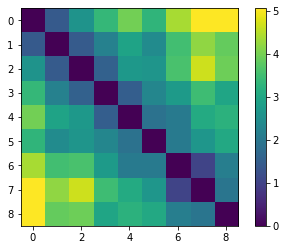

In [63]:
data_new = np.array(gmm.sample(10)[0])[9]
atomidentities = data_new[-9:]
print(np.around(atomidentities, 4))
data_new = data_new[:-9]
new_sample =squareform(pca.inverse_transform([data_new])[0])
new_sample = new_sample-np.min(new_sample)

plt.imshow(new_sample)
plt.colorbar()

# Turn EDM into real coordinates

First get coordinates:

In [64]:
def to_M_matrix(D):
    D1j = np.tile(D[0, :], len(D)).reshape(D.shape)
    Di1 = D1j.T
    return .5 * (-D + D1j + Di1)

def setPositions(mol_in, coords):
    conformer = mol_in.GetConformer(0)
    for i in range(mol_in.GetNumAtoms()):
        x,y,z = coords[i]
        conformer.SetAtomPosition(i,Point3D(x,y,z))
    return mol_in

D = new_sample**2
M = to_M_matrix(D)
S, U = np.linalg.eigh(M)

coord = np.matmul(U, np.diag(np.sqrt(np.abs(S))))
X = coord[:, -3:]


Get atom connectivity matrix (thanks to jan jensen xyz2mol)

In [65]:

atomicNumList= [6 if i<7 else 8 for i in atomidentities]


am, mol =xyz2AC(atomicNumList,X)


Add bonds using editable mol:

In [66]:
eMol = Chem.EditableMol(mol)

In [67]:
bonds = np.triu(am)
for j, k in zip(np.where(bonds)[0], np.where(bonds)[1]):
    print(j,k)
    try:
        eMol.AddBond(int(j),int(k))
    except:
        None


0 1
1 2
2 3
3 4
3 5
4 5
5 6
6 7


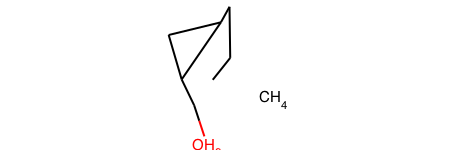

In [68]:
mol = eMol.GetMol()

Chem.rdmolfiles.MolToPDBFile(mol, 'tempmol.pdb', flavor=0)
mol

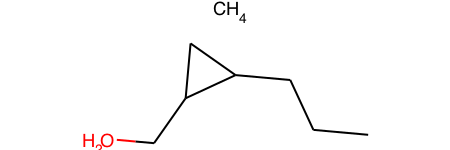

In [69]:
Chem.rdDepictor.Compute2DCoords(mol)

mol